In [ ]:
#| code-fold: true
#| code-summary: "Import Statements"
import pandas as pd
import numpy as np
# Dataviz
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from adjustText import adjust_text
# Geopatial
import geopandas as gpd
from shapely.geometry import box
import contextily as cx
import pygris.utils
import pygris
import osmnx as ox
# IO
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

In [ ]:
#| echo: false
#| output: false
# epsg = "EPSG:3857"
# cell_size = 1500
# bay_arrivals_hist = geospatial_histogram(
#     gdf_bay_proj, weights=None, cell_size=cell_size
# )
# hist_latlon = bay_arrivals_hist.to_crs(epsg)
# counties_latlon = county_shapes[
#     county_shapes["region"] == "San Francisco Bay Area"
# ].to_crs(epsg)
# hist_latlon[""] = hist_latlon.apply(
#     lambda row: f"""
#      <div style='font-size:12px; font-family:Arial; line-height:1.4;'>
#      {int(cell_size/1000)}x{int(cell_size/1000)}km area<br>
#     Transit Stops: {int(row['count'])}<br>Percentile: {round(sum(hist_latlon['count'].abs() < row['count']) / len(hist_latlon['count']), 3)}<br>
#     </div>
#     """,
#     axis=1,
# )
# m = sf_bay_county_shapes[sf_bay_county_shapes["region"] == "San Francisco Bay Area"].explore(
#     color="black",
#     fill=False,
#     linewidth=10,
#     alpha=0.5,
#     tiles="CartoDB Positron",
#     highlight=False,
#     tooltip=False,
#     name="Counties",
# )
# hist_latlon.explore(
#     m=m,
#     column="count",
#     cmap="Reds",
#     color="black",
#     style_kwds={'fillOpacity': .7, 'weight': 0},
#     tiles="",
#     vmax=100,
#     tooltip="",
#     legend=True,
#     legend_kwds={"caption": "Number of High Quality Public Transit Stops"},
# )
# hist_latlon.explore(
#     m=m,
#     highlight=False,
#     style_kwds={'fillOpacity': 0, 'weight': .1},
#     alpha=.5,
#     color="black",
#     fill=False,
#     tooltip=False,
# )

## Exercise 5: Adding Context

In [ ]:
gdf_sf = gdf_hq.copy()[gdf_hq.geometry.within(county_shapes[county_shapes['NAME'] == 'San Francisco'].iloc[0].geometry)]

Web maps need a special crs

In [ ]:
sf_no_water_web_map = bay_area_no_water[bay_area_no_water['NAME'] == 'San Francisco'].to_crs(PSEUDO_MERCATOR_CRS)
gdf_sf_web_map = gdf_sf.to_crs(PSEUDO_MERCATOR_CRS)

Lets look at BART

In [ ]:
bart_stops = gdf_sf_web_map[
    (gdf_sf_web_map['agency_primary'] == 'San Francisco Bay Area Rapid Transit District')
       ]

https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers

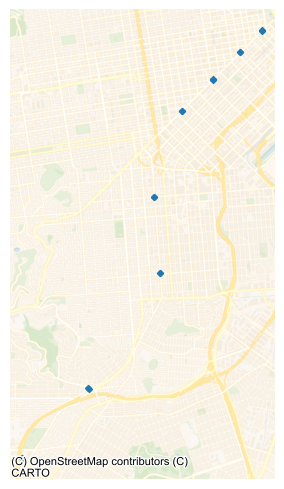

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)
ax.axis("off")
fig.tight_layout();

https://stackoverflow.com/questions/68175234/change-contextily-basemap-size/79653580#79653580

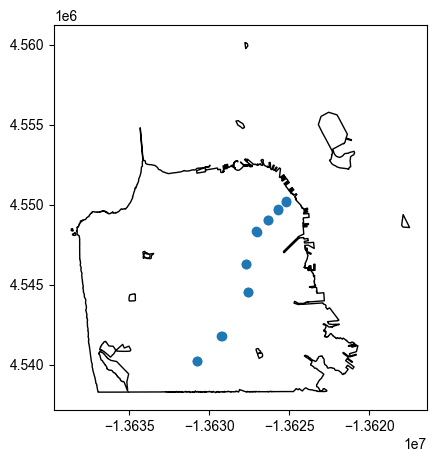

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sf_no_water_web_map.plot(ax=ax, facecolor="none")
bart_stops.plot(ax=ax);

In [ ]:
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
sf_bounds

minx   -1.363863e+07
miny    4.538246e+06
maxx   -1.361748e+07
maxy    4.560119e+06
Name: 0, dtype: float64

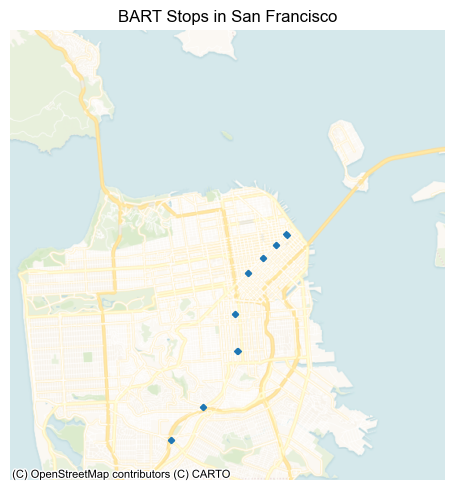

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
# Use another shape to determine the zoom/map size
assert sf_no_water_web_map.crs == bart_stops.crs
ax.set(xlim = (sf_bounds['minx'], sf_bounds['maxx']),
       ylim = (sf_bounds['miny'], sf_bounds['maxy'])
       )
ax.axis("off")
ax.set(title="BART Stops in San Francisco")
fig.tight_layout()
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)

### Physical Infrastructure Features with `osmnx`

Open Street Maps' features API requires us to pass in a bounding box in the WGS84 projects along with tags that select features and it returns all of the requested features within that bounding box. Here, I pass in the bay area's total bounds in the WGS84 projects, and specify subway rail (this is how Open Street Maps classifies BART).  

The code returns a geodataframe of all of the subway rail in the bay area, stored as line segments with various interesting characteristics (e.g. max speed, whether it's an underground or above ground segment, etc).

In [ ]:
sf_bart_web = (
    ox.features
    .features_from_bbox(
        bbox=sf_no_water_web_map.to_crs("EPSG:4326").total_bounds,
        tags={"railway": "subway"})
    .to_crs(PSEUDO_MERCATOR_CRS))

sf_bart_web.head(2)

geometry    name  \
element id                                                                    
way     24141635  LINESTRING (-13630727.47 4540516.258, -1363074...  M-Line   
        24141683  LINESTRING (-13630771.441 4540324.869, -136307...  M-Line   

                 network operator railway electrified frequency gauge layer  \
element id                                                                    
way     24141635    BART      NaN  subway        rail         0  1676    -1   
        24141683    BART      NaN  subway        rail         0  1676   NaN   

                 maxspeed                                          owner  \
element id                                                                 
way     24141635   36 mph  San Francisco Bay Area Rapid Transit District   
        24141683   36 mph  San Francisco Bay Area Rapid Transit District   

                 railway:preferred_direction tunnel voltage cutting level  \
element id                                                                  
way     24141635                     forward    yes    1000     NaN   NaN   
        24141683                     forward    NaN    1000     yes   NaN   

                 note wikipedia bridge service  
element id                                      
way     24141635  NaN       NaN    NaN     NaN  
        24141683  NaN       NaN    NaN     NaN